# Analisi Back Squat con Accelerometro

Questo notebook analizza i dati dell'accelerometro durante l'esecuzione di back squat, identificando automaticamente le diverse fasi del movimento:
- **Posizione iniziale (Standing)**
- **Fase eccentrica (Discesa)**
- **Posizione inferiore (Bottom)**
- **Fase concentrica (Salita)**

I dati vengono visualizzati con marker che indicano i cambiamenti di fase.

## 1. Import Librerie

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Configurazione per grafici più grandi e leggibili
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dati

In [42]:
# Carica il file CSV
filename = 'accel_data_20251118_234801.csv'

df = pd.read_csv(filename)

# Mostra le prime righe
print(f"📊 Dataset caricato: {len(df)} campioni")
print(f"⏱️  Durata: {df['Timestamp'].max() - df['Timestamp'].min():.2f} secondi")
print(f"📈 Frequenza di campionamento: ~{len(df)/(df['Timestamp'].max() - df['Timestamp'].min()):.1f} Hz\n")

df.head(10)

📊 Dataset caricato: 257 campioni
⏱️  Durata: 4.95 secondi
📈 Frequenza di campionamento: ~51.9 Hz



,Timestamp,X (g),Y (g),Z (g),Magnitude (g)
0,65.535,-0.218750,-0.84375,0.390625,0.955172
1,65.574,-0.218750,-0.84375,0.390625,0.955172
2,65.611,-0.218750,-0.84375,0.390625,0.955172
3,65.611,-0.218750,-0.84375,0.390625,0.955172
4,65.612,-0.218750,-0.84375,0.375000,0.948889
5,65.613,-0.218750,-0.84375,0.375000,0.948889
6,65.616,-0.234375,-0.84375,0.375000,0.952613
7,65.647,-0.234375,-0.84375,0.390625,0.958871
8,65.647,-0.218750,-0.84375,0.375000,0.948889
9,65.648,-0.218750,-0.84375,0.375000,0.948889


## 3. Visualizzazione Dati Grezzi

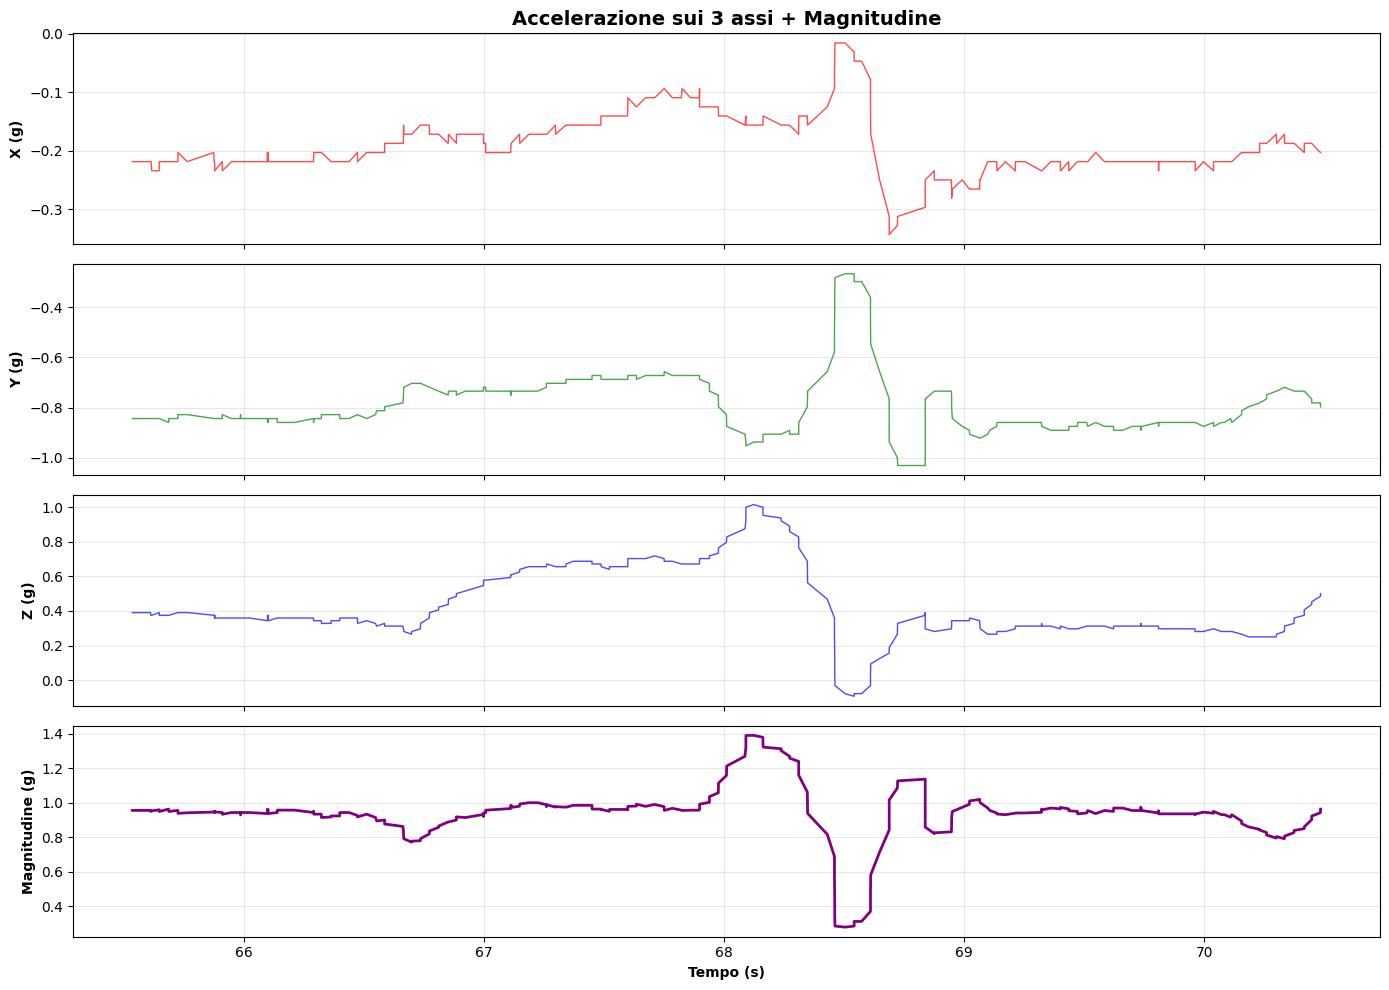

In [43]:
# Plot dei dati grezzi
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['Timestamp'], df['X (g)'], 'r-', alpha=0.7, linewidth=1)
axes[0].set_ylabel('X (g)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Accelerazione sui 3 assi + Magnitudine', fontsize=14, fontweight='bold')

axes[1].plot(df['Timestamp'], df['Y (g)'], 'g-', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Y (g)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Timestamp'], df['Z (g)'], 'b-', alpha=0.7, linewidth=1)
axes[2].set_ylabel('Z (g)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['Timestamp'], df['Magnitude (g)'], 'purple', linewidth=2)
axes[3].set_ylabel('Magnitudine (g)', fontweight='bold')
axes[3].set_xlabel('Tempo (s)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Smoothing e Preprocessing

In [44]:
# Applica smoothing gaussiano per ridurre il rumore
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sigma = 2  # Parametro di smoothing

df['X_smooth'] = gaussian_filter1d(df['X (g)'], sigma=sigma)
df['Y_smooth'] = gaussian_filter1d(df['Y (g)'], sigma=sigma)
df['Z_smooth'] = gaussian_filter1d(df['Z (g)'], sigma=sigma)
df['Mag_smooth'] = gaussian_filter1d(df['Magnitude (g)'], sigma=sigma)

# Calcola la derivata (velocità) della magnitudine per identificare cambiamenti
df['Mag_velocity'] = np.gradient(df['Mag_smooth'], df['Timestamp'])
df['Mag_velocity_smooth'] = gaussian_filter1d(df['Mag_velocity'], sigma=sigma)

print("✅ Smoothing applicato")

✅ Smoothing applicato


## 5. Rilevamento Fasi dello Squat

L'algoritmo identifica l'**inizio** di ogni fase del back squat:
1. **Baseline** - Posizione iniziale in piedi (stabile)
2. **Eccentrica** - Inizio discesa (accelerazione negativa su Y)
3. **Concentrica** - Inizio spinta verso l'alto (punto più basso + cambio direzione)
4. **Arresto** - Fine movimento (decelerazione vicino al top)
5. **Baseline** - Ritorno alla stabilità

In [45]:
# Analisi Magnitude con Soglie intorno alla Baseline
# Definiamo due soglie per rilevare quando la baseline viene rotta

mag = df['Mag_smooth'].values
timestamps = df['Timestamp'].values

print("🔍 ANALISI MAGNITUDE CON SOGLIE BASELINE")
print("=" * 80)

# Calcola baseline dai primi campioni stabili (primi 20%)
baseline_samples = int(len(mag) * 0.2)
baseline_value = np.median(mag[:baseline_samples])

# Definiamo due soglie simmetriche intorno alla baseline
threshold_percent = 0.05  # 5% della baseline
upper_threshold = baseline_value + (baseline_value * threshold_percent)
lower_threshold = baseline_value - (baseline_value * threshold_percent)

print(f"📊 Baseline: {baseline_value:.3f}g")
print(f"📊 Soglia superiore (+5%): {upper_threshold:.3f}g")
print(f"📊 Soglia inferiore (-5%): {lower_threshold:.3f}g")

# Trova quando le soglie vengono rotte
upper_breaks = np.where(mag > upper_threshold)[0]
lower_breaks = np.where(mag < lower_threshold)[0]

print(f"\n🔴 Soglia superiore rotta in {len(upper_breaks)} punti")
if len(upper_breaks) > 0:
    print(f"   Primo break: t={timestamps[upper_breaks[0]]:.2f}s (Mag={mag[upper_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[upper_breaks[-1]]:.2f}s (Mag={mag[upper_breaks[-1]]:.3f}g)")

print(f"\n🟢 Soglia inferiore rotta in {len(lower_breaks)} punti")
if len(lower_breaks) > 0:
    print(f"   Primo break: t={timestamps[lower_breaks[0]]:.2f}s (Mag={mag[lower_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[lower_breaks[-1]]:.2f}s (Mag={mag[lower_breaks[-1]]:.3f}g)")

print("=" * 80)

🔍 ANALISI MAGNITUDE CON SOGLIE BASELINE
📊 Baseline: 0.946g
📊 Soglia superiore (+5%): 0.993g
📊 Soglia inferiore (-5%): 0.899g

🔴 Soglia superiore rotta in 30 punti
   Primo break: t=67.90s (Mag=0.996g)
   Ultimo break: t=69.06s (Mag=0.996g)

🟢 Soglia inferiore rotta in 53 punti
   Primo break: t=66.55s (Mag=0.898g)
   Ultimo break: t=70.45s (Mag=0.895g)


## 6. Visualizzazione con Marker delle Fasi

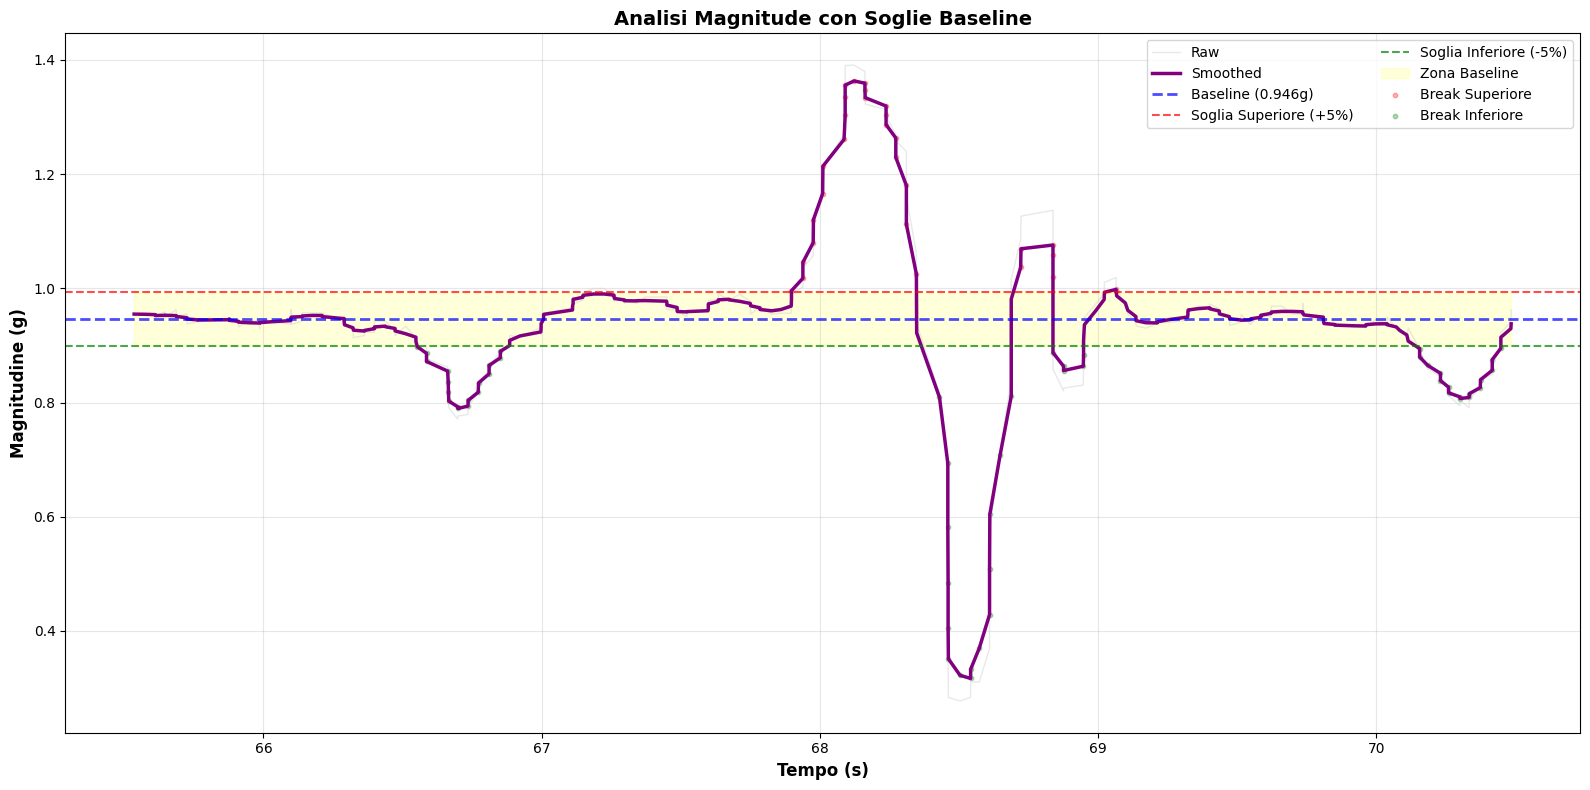

In [46]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot magnitudine
ax.plot(df['Timestamp'], df['Magnitude (g)'], 'lightgray', alpha=0.5, linewidth=1, label='Raw')
ax.plot(df['Timestamp'], df['Mag_smooth'], 'purple', linewidth=2.5, label='Smoothed')

# Linee delle soglie
ax.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline ({baseline_value:.3f}g)', alpha=0.7)
ax.axhline(y=upper_threshold, color='red', linestyle='--', linewidth=1.5, label=f'Soglia Superiore (+5%)', alpha=0.7)
ax.axhline(y=lower_threshold, color='green', linestyle='--', linewidth=1.5, label=f'Soglia Inferiore (-5%)', alpha=0.7)

# Zona baseline (fill between)
ax.fill_between(df['Timestamp'], lower_threshold, upper_threshold, color='yellow', alpha=0.15, label='Zona Baseline')

# Evidenzia i punti dove le soglie vengono rotte
if len(upper_breaks) > 0:
    ax.scatter(timestamps[upper_breaks], mag[upper_breaks], color='red', s=10, alpha=0.3, label='Break Superiore')

if len(lower_breaks) > 0:
    ax.scatter(timestamps[lower_breaks], mag[lower_breaks], color='green', s=10, alpha=0.3, label='Break Inferiore')

ax.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
ax.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
ax.set_title('Analisi Magnitude con Soglie Baseline', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

## 7. Rilevamento Ripetizioni con Pattern Matching

Algoritmo basato su **sequenze di picchi di accelerazione**:

**FASE ECCENTRICA (discesa)**:
- Pattern: PICCO_GIÙ → BASE → (eventuale PICCO_SU per frenata)

**FASE CONCENTRICA (spinta)** ← qui calcoliamo VBT:
- Pattern: PICCO_SU → BASE → PICCO_GIÙ → BASE finale

L'algoritmo cerca queste sequenze caratteristiche invece di soglie assolute.

In [47]:
# Algoritmo Pattern Matching per Rilevamento Squat
# Basato su sequenze di picchi di accelerazione

from scipy.signal import find_peaks

# Parametri
BASELINE_ZONE = 0.08  # ±8% intorno a baseline = "stabile"
PEAK_PROMINENCE = 0.15  # Prominenza minima per considerare un picco
MIN_REP_DURATION = 0.5
MAX_REP_DURATION = 4.0
REFRACTORY_PERIOD = 0.8

mag = df['Mag_smooth'].values
y_acc = df['Y_smooth'].values
timestamps = df['Timestamp'].values

print("🏋️ RILEVAMENTO SQUAT CON PATTERN MATCHING")
print("=" * 90)

# 1. CALCOLA BASELINE
baseline_samples = int(len(mag) * 0.2)
baseline_value = np.median(mag[:baseline_samples])
baseline_upper = baseline_value * (1 + BASELINE_ZONE)
baseline_lower = baseline_value * (1 - BASELINE_ZONE)

print(f"📊 Baseline: {baseline_value:.3f}g (zona: {baseline_lower:.3f}g - {baseline_upper:.3f}g)")

# 2. TROVA TUTTI I PICCHI (sopra e sotto baseline)
# Picchi SOPRA baseline (accelerazioni/decelerazioni)
peaks_above, props_above = find_peaks(mag, prominence=PEAK_PROMINENCE, height=baseline_upper)

# Picchi SOTTO baseline (minimi durante discesa)
# Inverti il segnale per trovare i "picchi" verso il basso
peaks_below, props_below = find_peaks(-mag, prominence=PEAK_PROMINENCE, height=-baseline_lower)

print(f"\n🔍 Picchi rilevati:")
print(f"   Sopra baseline: {len(peaks_above)} picchi")
print(f"   Sotto baseline: {len(peaks_below)} picchi")

# 3. CERCA PATTERN ECCENTRICO-CONCENTRICO
valid_reps = []
last_rep_end_time = -REFRACTORY_PERIOD

# Classifica ogni punto come: ABOVE (sopra baseline), BELOW (sotto), o BASE (nella zona)
signal_state = np.full(len(mag), 'BASE', dtype='U10')
signal_state[mag > baseline_upper] = 'ABOVE'
signal_state[mag < baseline_lower] = 'BELOW'

# Trova transizioni di stato
state_changes = []
for i in range(1, len(signal_state)):
    if signal_state[i] != signal_state[i-1]:
        state_changes.append({
            'idx': i,
            'time': timestamps[i],
            'from': signal_state[i-1],
            'to': signal_state[i],
            'mag': mag[i]
        })

print(f"   Transizioni di stato: {len(state_changes)}")

# 4. PATTERN MATCHING: cerca sequenze caratteristiche
# Pattern completo squat: BASE → BELOW/ABOVE (eccentrica) → BELOW (bottom) → ABOVE (concentrica) → BASE
i = 0
while i < len(state_changes) - 3:
    # Cerca inizio rep: uscita da BASE
    if state_changes[i]['from'] == 'BASE':
        rep_start_idx = state_changes[i]['idx']
        rep_start_time = state_changes[i]['time']
        
        # Applica periodo refrattario
        if rep_start_time - last_rep_end_time < REFRACTORY_PERIOD:
            i += 1
            continue
        
        # Cerca il ritorno a BASE finale (chiusura del pattern)
        for j in range(i+1, min(i+15, len(state_changes))):  # Max 15 transizioni
            if state_changes[j]['to'] == 'BASE':
                rep_end_idx = state_changes[j]['idx']
                rep_end_time = state_changes[j]['time']
                rep_duration = rep_end_time - rep_start_time
                
                # Valida durata
                if MIN_REP_DURATION <= rep_duration <= MAX_REP_DURATION:
                    # Analizza la sequenza interna per trovare bottom e picco concentrico
                    event_slice = slice(rep_start_idx, rep_end_idx + 1)
                    mag_segment = mag[event_slice]
                    y_segment = y_acc[event_slice]
                    
                    # Bottom = minimo di mag nel segmento
                    bottom_relative = np.argmin(mag_segment)
                    bottom_idx = rep_start_idx + bottom_relative
                    bottom_time = timestamps[bottom_idx]
                    
                    # Picco concentrico = massimo di mag DOPO bottom
                    if bottom_relative < len(mag_segment) - 1:
                        concentric_segment = mag_segment[bottom_relative:]
                        concentric_peak_relative = np.argmax(concentric_segment)
                        concentric_peak_idx = bottom_idx + concentric_peak_relative
                        concentric_peak_time = timestamps[concentric_peak_idx]
                    else:
                        concentric_peak_idx = rep_end_idx
                        concentric_peak_time = rep_end_time
                    
                    valid_reps.append({
                        'rep_num': len(valid_reps) + 1,
                        'start_idx': rep_start_idx,
                        'bottom_idx': bottom_idx,
                        'concentric_peak_idx': concentric_peak_idx,
                        'end_idx': rep_end_idx,
                        'start_time': rep_start_time,
                        'bottom_time': bottom_time,
                        'concentric_peak_time': concentric_peak_time,
                        'end_time': rep_end_time,
                        'duration': rep_duration,
                        'mag_start': mag[rep_start_idx],
                        'mag_bottom': mag[bottom_idx],
                        'mag_peak': mag[concentric_peak_idx],
                        'mag_end': mag[rep_end_idx]
                    })
                    
                    last_rep_end_time = rep_end_time
                    i = j + 1
                    break
        else:
            i += 1
    else:
        i += 1

print(f"\n✅ RIPETIZIONI VALIDE: {len(valid_reps)}")
print("=" * 90)

# 5. CALCOLO VBT - Mean Velocity dalla fase concentrica
if len(valid_reps) > 0:
    print(f"\n🚀 CALCOLO VELOCITY BASED TRAINING (VBT)")
    print("=" * 90)
    
    for rep in valid_reps:
        # Fase concentrica: da bottom al picco concentrico
        concentric_slice = slice(rep['bottom_idx'], rep['concentric_peak_idx'] + 1)
        time_concentric = timestamps[concentric_slice]
        
        # Usa magnitudine invece di Y - sottrai baseline per accelerazione netta
        mag_concentric = mag[concentric_slice]
        
        if len(mag_concentric) < 2:
            rep['mean_velocity'] = 0.0
            rep['peak_velocity'] = 0.0
            continue
        
        mag_accel_net = mag_concentric - baseline_value
        
        # Integrazione: v(t) = v(t-1) + a(t) * dt, con v(0) = 0 al bottom
        velocity = [0.0]
        for k in range(1, len(mag_accel_net)):
            dt = time_concentric[k] - time_concentric[k-1]
            v_new = velocity[-1] + mag_accel_net[k] * dt
            velocity.append(v_new)
        
        velocity = np.array(velocity)
        
        # Metriche VBT
        positive_velocity = velocity[velocity > 0]
        if len(positive_velocity) > 0:
            mean_velocity = np.mean(positive_velocity)
            peak_velocity = np.max(velocity)
        else:
            mean_velocity = 0.0
            peak_velocity = 0.0
        
        rep['mean_velocity'] = mean_velocity
        rep['peak_velocity'] = peak_velocity
        rep['eccentric_duration'] = rep['bottom_time'] - rep['start_time']
        rep['concentric_duration'] = rep['concentric_peak_time'] - rep['bottom_time']
        
        print(f"\n📊 REP #{rep['rep_num']}")
        print(f"   ⏱️  Sequenza: START {rep['start_time']:.2f}s → BOTTOM {rep['bottom_time']:.2f}s → PEAK {rep['concentric_peak_time']:.2f}s → END {rep['end_time']:.2f}s")
        print(f"   ⏱️  Durate: Tot={rep['duration']:.2f}s | Ecc={rep['eccentric_duration']:.2f}s | Conc={rep['concentric_duration']:.2f}s")
        print(f"   📈 Magnitudine: {rep['mag_start']:.3f}g → {rep['mag_bottom']:.3f}g → {rep['mag_peak']:.3f}g → {rep['mag_end']:.3f}g")
        print(f"   🚀 Mean Velocity: {mean_velocity:.3f} m/s")
        print(f"   ⚡ Peak Velocity: {peak_velocity:.3f} m/s")
    
    print("=" * 90)
    
    # Statistiche aggregate
    if len(valid_reps) > 1:
        mean_vels = [r['mean_velocity'] for r in valid_reps]
        peak_vels = [r['peak_velocity'] for r in valid_reps]
        durations = [r['duration'] for r in valid_reps]
        
        print(f"\n📈 STATISTICHE AGGREGATE ({len(valid_reps)} ripetizioni)")
        print(f"   Mean Velocity media: {np.mean(mean_vels):.3f} m/s (±{np.std(mean_vels):.3f})")
        print(f"   Peak Velocity media: {np.mean(peak_vels):.3f} m/s (±{np.std(peak_vels):.3f})")
        print(f"   Durata media: {np.mean(durations):.2f}s (±{np.std(durations):.2f})")
        print("=" * 90)
else:
    print("⚠️ Nessuna ripetizione valida rilevata")

🏋️ RILEVAMENTO SQUAT CON PATTERN MATCHING
📊 Baseline: 0.946g (zona: 0.870g - 1.022g)

🔍 Picchi rilevati:
   Sopra baseline: 2 picchi
   Sotto baseline: 2 picchi
   Transizioni di stato: 12

✅ RIPETIZIONI VALIDE: 1

🚀 CALCOLO VELOCITY BASED TRAINING (VBT)

📊 REP #1
   ⏱️  Sequenza: START 66.66s → BOTTOM 66.70s → PEAK 68.12s → END 68.35s
   ⏱️  Durate: Tot=1.69s | Ecc=0.04s | Conc=1.42s
   📈 Magnitudine: 0.855g → 0.790g → 1.363g → 0.922g
   🚀 Mean Velocity: 0.015 m/s
   ⚡ Peak Velocity: 0.057 m/s


## 8. Visualizzazione Ripetizioni Rilevate con VBT

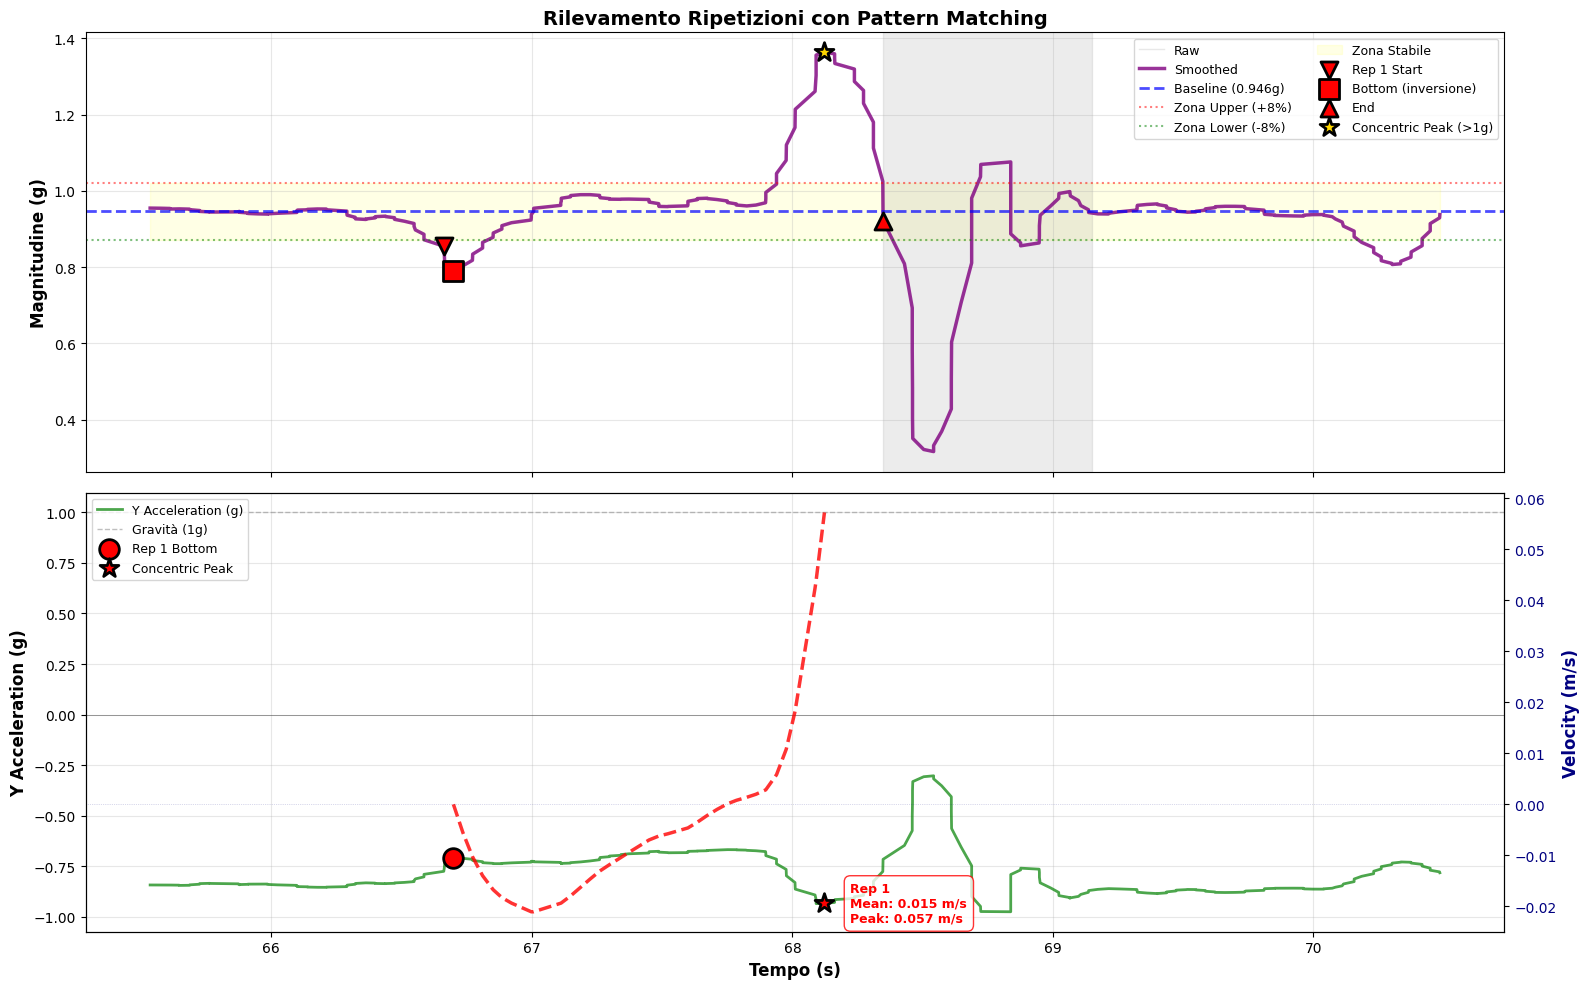

✅ Visualizzazione completata


In [48]:
if len(valid_reps) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # SUBPLOT 1: Magnitudine con marker delle fasi
    ax1 = axes[0]
    ax1.plot(timestamps, mag, 'lightgray', alpha=0.5, linewidth=1, label='Raw')
    ax1.plot(timestamps, mag, 'purple', linewidth=2.5, label='Smoothed', alpha=0.8)
    
    # Zone baseline (pattern matching)
    ax1.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline ({baseline_value:.3f}g)', alpha=0.7)
    ax1.axhline(y=baseline_upper, color='red', linestyle=':', linewidth=1.5, label=f'Zona Upper (+{BASELINE_ZONE*100:.0f}%)', alpha=0.5)
    ax1.axhline(y=baseline_lower, color='green', linestyle=':', linewidth=1.5, label=f'Zona Lower (-{BASELINE_ZONE*100:.0f}%)', alpha=0.5)
    ax1.fill_between(timestamps, baseline_lower, baseline_upper, color='yellow', alpha=0.1, label='Zona Stabile')
    
    # Marker per ogni ripetizione
    colors_rep = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # Start, Bottom, End - add labels only for first rep to avoid legend clutter
        ax1.scatter(rep['start_time'], rep['mag_start'], s=150, marker='v', color=color, 
                   edgecolors='black', linewidths=2, zorder=10, 
                   label=f"Rep {rep['rep_num']} Start" if i == 0 else None)
        ax1.scatter(rep['bottom_time'], rep['mag_bottom'], s=200, marker='s', color='red', 
                   edgecolors='black', linewidths=2, zorder=10,
                   label='Bottom (inversione)' if i == 0 else None)
        ax1.scatter(rep['end_time'], rep['mag_end'], s=150, marker='^', color=color, 
                   edgecolors='black', linewidths=2, zorder=10,
                   label='End' if i == 0 else None)
        ax1.scatter(rep['concentric_peak_time'], rep['mag_peak'], s=200, marker='*', 
                   color='gold', edgecolors='black', linewidths=2, zorder=10,
                   label='Concentric Peak (>1g)' if i == 0 else None)
        
        # Zona refrattaria dopo ogni rep
        refractory_end = rep['end_time'] + REFRACTORY_PERIOD
        ax1.axvspan(rep['end_time'], min(refractory_end, timestamps[-1]), 
                   color='gray', alpha=0.15, zorder=1)
    
    ax1.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
    ax1.set_title('Rilevamento Ripetizioni con Pattern Matching', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=9, ncol=2)
    
    # SUBPLOT 2: Accelerazione Y con velocità integrata
    ax2 = axes[1]
    ax2.plot(timestamps, y_acc, 'green', linewidth=2, alpha=0.7, label='Y Acceleration (g)')
    ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Gravità (1g)')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Plot velocità per ogni ripetizione
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # Ricostruisci velocità per il plot usando magnitudine
        concentric_slice = slice(rep['bottom_idx'], rep['concentric_peak_idx'] + 1)
        mag_concentric = mag[concentric_slice]
        time_concentric = timestamps[concentric_slice]
        mag_accel_net = mag_concentric - baseline_value
        
        velocity_plot = np.zeros(len(mag_accel_net))
        for j in range(1, len(velocity_plot)):
            dt_step = time_concentric[j] - time_concentric[j-1]
            velocity_plot[j] = velocity_plot[j-1] + mag_accel_net[j] * dt_step
        
        # Plot su asse secondario
        ax2_vel = ax2.twinx()
        ax2_vel.plot(time_concentric, velocity_plot, color=color, linewidth=2.5, 
                    linestyle='--', alpha=0.8, label=f"Rep {rep['rep_num']} Velocity")
        ax2_vel.set_ylabel('Velocity (m/s)', fontweight='bold', fontsize=12, color='navy')
        ax2_vel.tick_params(axis='y', labelcolor='navy')
        ax2_vel.axhline(y=0, color='navy', linestyle=':', linewidth=0.5, alpha=0.3)
        
        # Marker bottom (inversione) e picco concentrico
        ax2.scatter(rep['bottom_time'], y_acc[rep['bottom_idx']], s=200, marker='o', 
                   color=color, edgecolors='black', linewidths=2, zorder=10, 
                   label=f"Rep {rep['rep_num']} Bottom" if i == 0 else None)
        ax2.scatter(rep['concentric_peak_time'], y_acc[rep['concentric_peak_idx']], s=200, marker='*', 
                   color=color, edgecolors='black', linewidths=2, zorder=10,
                   label='Concentric Peak' if i == 0 else None)
        
        # Aggiungi testo con metriche VBT vicino al picco concentrico
        text_x = rep['concentric_peak_time'] + 0.1
        text_y = y_acc[rep['concentric_peak_idx']]
        ax2.text(text_x, text_y, 
                f"Rep {rep['rep_num']}\nMean: {rep['mean_velocity']:.3f} m/s\nPeak: {rep['peak_velocity']:.3f} m/s",
                fontsize=9, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=color, alpha=0.8),
                verticalalignment='center')
    
    ax2.set_ylabel('Y Acceleration (g)', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizzazione completata")
else:
    print("⚠️ Nessuna ripetizione da visualizzare")

## 10. Riepilogo e Conclusioni

Questo notebook ha analizzato i dati dell'accelerometro durante l'esecuzione di back squat identificando le **5 fasi** del movimento:

### Fasi Identificate:
1. 🟦 **Baseline Start** - Posizione iniziale stabile in piedi
2. 🔴 **Eccentrica** - Inizio della discesa (fase negativa)
3. 🟢 **Concentrica** - Inizio della spinta verso l'alto (punto più basso)
4. 🟠 **Arresto** - Decelerazione e fine del movimento verso l'alto
5. 🔵 **Baseline End** - Ritorno alla posizione stabile

### Marker sui Grafici:
- **Quadrati blu** (□) = Baseline
- **Triangoli rossi giù** (▼) = Inizio fase eccentrica
- **Triangoli verdi su** (▲) = Inizio fase concentrica
- **Diamanti arancioni** (◆) = Arresto
- **Quadrati ciano** (□) = Ritorno baseline

### Analisi Completata:
✅ Identificazione automatica delle transizioni di fase  
✅ Marker visualizzati all'**inizio** di ogni fase  
✅ Analisi temporale delle durate eccentriche/concentriche  
✅ Statistiche complete per ogni ripetizione  
✅ Visualizzazione 3D della traiettoria completa